# Lab 4 - Interlude: from regression to classification

So far we saw _regression_ problems where the inputs were _one-dimensional_, that is they consisted of **real values** ($x_i \in \mathbb{R}$), and the goal was to find a curve that fitted the data points.

We now introduce a different family of problems, namely _classification_ problems, whose setting is slightly different.

The main difference with respect to regression problems is the _nature_ of the outputs: while for regression outputs consisted of real values, in classification tasks the outputs are _class labels_ that indicate to which 
category (or class) a sample belongs.
While we're here, we put ourselves in a more general setting by allowing the **inputs** to be _vectors_ of a fixed length $d$, which we'll refer to as _data dimensionality_.

For instance, a dataset may consist of the expression levels of several genes for a group of individuals divided in two groups: patients affected by some disease and healthy individuals.

In this example, the dataset is given in the form of a **data matrix** $X \in \mathbb{R}^{n \times d}$ (the inputs) and a **labels vector** $\mathbf{y} \in \{ \mathrm{healthy}, \mathrm{sick} \}^n$ (the outputs)

Just to be clear, the vector $\mathbf{y}$ is essentially a list of $n$ labels, where the $i$-th label is associated to the sample represented by the $i$-th row of the $X$ data matrix.

<img style="float: left;" src="info.png" width="20px"> &nbsp; **Notation**: from now on, we will use the letter $d$ to indicate data dimensionality, and $n$ to indicate the number of samples in a dataset. When iterating, $i$ will be used for rows (i.e. samples) and $j$ for columns (i.e. variables/features). Anyone caught using other symbols will be persecuted.

In cases such as the above example, where the number of categories is **two**, the task is called _binary classification_.

We'll see now how almost all concepts introduced when talking about regression still hold for classification, albeit with some minor changes

Main concepts:

 * [Binary] Classification
 * Data dimensionality

## Imports and setup

The usual stuff:

 * Magic command `%matplotlib inline` so that plots are displayed correctly in the notebook.
 * `matplotlib` followed by `seaborn` in order to have fancy plots
 * `numpy` _et similia_ for number crunching.
 
Additional libraries will be imported whenever they are needed

In [1]:
%matplotlib inline

import matplotlib
from matplotlib import pyplot as plt

import seaborn

import numpy as np

## Dataset generation

This time we will generate a synthetic classification dataset using a function from the `scikit-learn` library. There are many parameters that control various characteristics of the dataset. The default values for a few of them are not ok for our purposes, so we have to override them.

Print the shape of X and y to familiarize with the format of those arrays.

<img style="float: left;" src="info.png" width="20px"> &nbsp; **Hint**: The shape of a `numpy` array is available through the object's _property_ `shape`.

```python
import numpy as np

X = np.array([[1,2], [3,4], [5,6]])
print(X.shape)
```

In [2]:
from sklearn.datasets import make_classification

### Set the number of samples and dimensions
### With d = 2 we will still be able to visualize our dataset
n, d = 100, 2

np.random.seed(2)

X, y = make_classification(n_samples=n, 
                           n_features=d, 
                           n_informative=d, 
                           n_redundant=0, 
                           n_repeated=0, 
                           n_classes=2, 
                           n_clusters_per_class=1, 
                           flip_y=0.05, 
                           class_sep=1.0, 
                           )

### BEGIN STUDENT ###
# Print the shape of X and y

### END STUDENT ###

Shape of X: (100, 2)
Shape of y: (100,)


Notice how the shape of X is a tuple of **two** elements, as it is a bidimensional matrix, while the shape of y is a tuple of only **one** element, as y is a vector.

Below, a plot of the dataset.

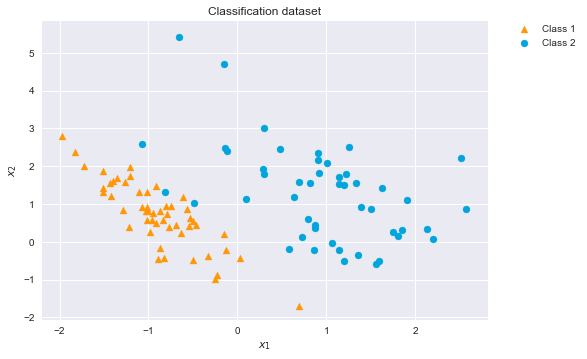

In [3]:
### Save the colors so that we ca use them later
colors = {
    'orange':'#FF9707',
    'azure': '#00A5DD',
}

fig, ax = plt.subplots()

ax.set_title("Classification dataset")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")

X1 = X[np.argwhere(y == 1).ravel(), :]
X0 = X[np.argwhere(y == 0).ravel(), :]

ax.scatter(X0[:,0], X0[:,1], c=colors['orange'], marker='^', label='Class 1');
ax.scatter(X1[:,0], X1[:,1], c=colors['azure'], label='Class 2');

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

There are several differences with respect to the plot of a regression dataset: the most important one is that while for regression inputs lie on one of the axis (the horizontal one) and outputs on the other one (the vertical one), here both axis are used to represent the input, which is bidimensional, while the output (the category) is represented using different symbols and colors for samples belonging to the two classes.

Let's break the code down:

```python
X1 = X[np.argwhere(y == 1).ravel(), :]
X0 = X[np.argwhere(y == 0).ravel(), :]
```

With this code, we split the dataset in two: those points whose label is 1, and those whose label is 0. The `make_classification` function encodes the different classes using integers, starting from 0. Any other choice of two different integers (such as -1 and +1) is fine.

```python
ax.scatter(X0[:,0], X0[:,1], c=colors['orange'], label='Class 1');
ax.scatter(X1[:,0], X1[:,1], c=colors['azure'], marker='^', label='Class 2');
```

Then, we plot the two points separately, by using the first column of each submatrix for the horizontal axis and the other one for the vertical axis. Remember that the syntax `X[:, 0]` is used to select **all rows** (`:`), but **only the first colun** (`0`).

This example however has a limited use as when the number of dimensions of the input is greater than **three** (in which case you can still visualize points with a 3D plot) you cannot plot the points in their originale space. Because, you know, we live in a 3D world.

## Learning algorithms for classification

Now to the good stuff: what do I do to infer a function that predicts the _labels_, rather than a real value?

Good news, everyone! As promised, it's done [almost] in the same way as for regression!

The principle, for most algorithms for classification, is actually the same: we minimize a functional whose terms are a _loss function_, which reflects how bad we're predicting the output values, and possibly some _penalty_ term to limit the complexity of the function. 

$$
H[f] = L(\mathbf{y}, f(X)) + \alpha V(f)
$$

We can still fit a linear model to the data and use the _square loss_ as loss function or we can choose something else, such as the _logistic loss_ (used in _Logistic Regression_, which despite the name is actually a classification algorithm).

You may point out that the output of a linear function is still a real value and not a discrete category: you're right, the fact is that in this case we're not actually looking for a curve that passes as close as possible to the training data but rather we're trying to find a _plane_ (or, more generally, a _hyperplane_) which splits the input space ($\mathbb{R}^w$ in the example above) in two. On one side, characterized by $f(\mathbf{x}) > 0$, the function will assign all inputs to one of the two categories, on the other one ($f(\mathbf{x}) < 0$) it will assign inputs to the other category. The points that satisfy equation $f(\mathbf{x}) = 0$ are exactly those of the hyperplane.
To predict the class of an input, simply take the _sign_ of $f(\mathbf{x})$.

<img style="float: left;" src="warning.png" width="20px"> &nbsp; **Warning**: You could be tempted by using a more intuitive choice for a loss function, such as the _0-1 loss_, which is 0 if the label is predicted correctly and 1 otherwise. The problem is that this function is _non differentiable_, and the minimization of a functional using this loss would be non trivial. Other choices, such as the square loss, are differentiable and thus quite fit for this task.

The procedure for training a model is the same:

 1. Instantiate an object corresponding to the algorithm you want to use
 1. Train it on the training set, using both inputs and outputs, with method `fit`
 1. Predict the labels corresponding to the inputs of the test set with method `predict`
 
For instance (assume `X` and `y` already exist)

```python

from sklearn.linear_model import RidgeClassifier

clf = RidgeClassifier()
clf.fit(X, y)
y_pred = clf.predict(X)
```

In the box below, fit a classifier with `RidgeClassifier` using the whole dataset.

In [4]:
### BEGIN STUDENTS ###
# clf = ...

### END STUDENTS ###

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='auto',
        tol=0.001)

Now we plot the results

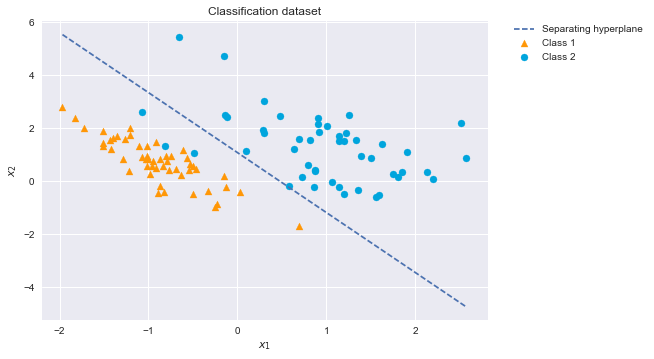

In [5]:
### Save the colors so that we ca use them later
colors = {
    'orange':'#FF9707',
    'azure': '#00A5DD',
}

fig, ax = plt.subplots()

ax.set_title("Classification dataset")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")

X1 = X[np.argwhere(y == 1).ravel(), :]
X0 = X[np.argwhere(y == 0).ravel(), :]

ax.scatter(X0[:,0], X0[:,1], c=colors['orange'], marker='^', label='Class 1');
ax.scatter(X1[:,0], X1[:,1], c=colors['azure'], label='Class 2');

### Prepare ticks for separating line
xmin = X[:, 0].min()
xmax = X[:, 0].max()

### Stuff to compute separating hyperplane...
### Hint: this comes from putting <x, w> + c = 0
w1 = clf.coef_[0, 0]
w2 = clf.coef_[0, 1]
c = clf.intercept_[0]

sep = lambda x : -w1/w2*x-c/w2

ticks = np.linspace(xmin, xmax, 100)
y_ticks = sep(ticks)

ax.plot(ticks, y_ticks, ls='--', label='Separating hyperplane');

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

### Model selection

Now that you've seen that things work basically in the same way, try to implement again the model selection 
pipeline seen in the previous lab, using `GridSearchCV`. Try and experiment with other algorithms as well, such as `sklearn.neighbors.KNeighborsClassifier` ([docs here]( http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)) and `sklearn.linear_model.LogisticRegression` ([docs here](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)).

In [6]:
### BEGIN STUDENTS ###

### END STUDENTS ###

## Classification report

A useful tool to determine how well your classifier performed is to check a few statistics. `sklearn.metrics.classification_report` (docs [here](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)) and `sklearn.metrics.confusion_matrix` (docs [here](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix))  do just that.

In the next cell, you are given a dataset of 150 samples divided in two classes. Use 100 for training and the remaining 50 for test. Then print some statistics.

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

X, y = make_classification(n_samples=150, 
                           n_features=d, 
                           n_informative=d, 
                           n_redundant=0, 
                           n_repeated=0, 
                           n_classes=2, 
                           n_clusters_per_class=1, 
                           flip_y=0.1, 
                           class_sep=1.0, 
                           )


### BEGIN STUDENTS ###

### END STUDENTS ###

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

NameError: name 'y_test' is not defined

### More learning algorithms

Just so that you know, there are lots of learning algorithms for classification which do not rely on linear models. A few examples are k-NN, random forest and SVMs with non-linear kernels. All of these algorithms are available in the `scikit-learn` package and use the same syntax, so it's just a matter of knowing what you're doing.